# Differential Equation Solver Using Neural Networks [Travis Murphy]

In this project, we use a neural network to solve the IVP $y'(x) = y(x), y(0) = 1$. The method used here is a numerical approximation method for differential equations that yields an analytic function and uses the advatages of neural network computing.

Our neural network model consists of an input layer, a hidden layer with sigmoid activation function, and an output layer. The model is designed such that the cost function we minimize is the sum of squared differences between the left and right sides of the differential equation.

## Mathematical Description

Given the ordinary differential equation $y'(x) = y(x)$, with initial condition $y(0) = y_0 = 1$, the idea is to approximate $y(x)$ using a neural network. Please recall/note that the solution to the above IVP is $y(x) =e^x$.

The input layer of the neural network are x-values within a desired domain over which the solution will be obtained. These can be uniformly or randomly distributed through the domain.

The output of the network yields the weights in the arrays $U, V,b$. Those weights are the parameters of the *trial solution* shown below:

$$y(x_j;U_i,V_i,b_i) = y_0 + \Sigma_{j}^{m}\Sigma_{i}^{n} \ \frac{U_ix_j}{1+e^{-(V_ix_j + b_i)}} $$

where $m$ is the number of x-values chosen in the domain over which the network is trained to approximate the solution, and $n$ is the number of weights for each parameter of the trial solution. Note how the trial solution is constructed from sigmoidal basis functions and satisfies the IC $y(0)=1$ by design.

A cost function is then built directly from the DE itself. In order to model the derivative term(s) of the cost function, the gradient of the trial solution with respect to the inputs:

$$J(x_j;U_i,V_i,b_i) = \Sigma_{j}\Sigma_{i} [y-y']^2$$

Gradients of the cost function with respect to the parameters are then computed and used to perform gradient descent to train the model. The trial solution with the trained weights constitutes the NN solution to the given DE.

The necessary gradients are computed by means of *automatic differentiation*, which is a hybrid approach to differentiation distinct from either symbolic or numerical differentiation. The results are highly accurate and computationally efficient.

In [ ]:
# Script to solve y'(x) = y(x), y(0) = 1

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


%matplotlib inline
np.random.seed(1)


# Desmos demo of explicit cost function and gradients as well as plot of solution
# https://www.desmos.com/calculator/hgw4tvvcox

# Model weights and inputs and gradient weights initialized
X = tf.Variable(tf.constant([[-0.25,0.1, 0.01,0.1, 0.25, 0.5]], name = "X", dtype=tf.float64),trainable=False)
U = tf.Variable(tf.constant([[0.1, -0.09, -0.05, 0.42, 0.134]], name = "U", dtype=tf.float64))
V = tf.Variable(tf.constant([[-0.74, -0.17, 0.29, -0.420, 0.37]], name = "V", dtype=tf.float64))
b = tf.Variable(tf.constant([[-0.1, 0.37, 0.04, -0.2, 0.56]], name = "b", dtype=tf.float64))
JgradU = tf.Variable(tf.constant([[0, 0, 0]], name = "jgradU", dtype=tf.float64))
JgradV = tf.Variable(tf.constant([[0, 0, 0]], name = "jgradV", dtype=tf.float64))
jgradb = tf.Variable(tf.constant([[0, 0, 0]], name = "jgradb", dtype=tf.float64))

# Number of neurons and inputs
N = U.shape[1]
n = X.shape[1]

print("Inputs", X)
print(" ")
print("U_weights", U)
print(" ")
print("V_weights", V)
print(" ")
print("b_weights", b)
print(" ")

# Learning rate
alpha = 0.1

for i in range(100):

    with tf.GradientTape(persistent = True) as gfg2:

        gfg2.watch(U)
        gfg2.watch(V)
        gfg2.watch(b)

        with tf.GradientTape(persistent=True) as gfg1:

            gfg1.watch(X)

# Let y(x)
            xsig = tf.multiply(tf.multiply(1/(1 + tf.exp(-1*(tf.matmul(tf.transpose(X),V) + b))), U),tf.transpose(X))

# The cost function is the differential equation expressed as a sum of squared differnces
        J  = tf.reduce_sum((tf.ones([1,X.shape[1]],dtype=tf.float64) + tf.reduce_sum(xsig, axis = 1) - tf.reduce_sum(gfg1.gradient(xsig, X), axis = 0))**2)


    JgradU = tf.Variable(gfg2.gradient(J, U))
    JgradV = tf.Variable(gfg2.gradient(J, V))
    Jgradb =  tf.Variable(gfg2.gradient(J, b))

    U = U - alpha*JgradU
    V = V - alpha*JgradV
    b = b - alpha*Jgradb


print("\nFinal Cost: ", J.numpy())
print("\nFinal Weights:")
print("\nU: ", U.numpy())
print("\nV: ", V.numpy())
print("\nb: ", b.numpy())


Inputs <tf.Variable 'Variable:0' shape=(1, 6) dtype=float64, numpy=array([[-0.25,  0.1 ,  0.01,  0.1 ,  0.25,  0.5 ]])>
 
U_weights <tf.Variable 'Variable:0' shape=(1, 5) dtype=float64, numpy=array([[ 0.1  , -0.09 , -0.05 ,  0.42 ,  0.134]])>
 
V_weights <tf.Variable 'Variable:0' shape=(1, 5) dtype=float64, numpy=array([[-0.74, -0.17,  0.29, -0.42,  0.37]])>
 
b_weights <tf.Variable 'Variable:0' shape=(1, 5) dtype=float64, numpy=array([[-0.1 ,  0.37,  0.04, -0.2 ,  0.56]])>
 

Final Cost:  0.01222806471740535

Final Weights:

U:  [[-0.50393138  0.07724752  0.74932494  0.47787062  1.12535717]]

V:  [[-0.77579785  0.0279396   0.81950692  0.20943787  1.10528634]]

b:  [[-0.08689774  0.31837342 -0.05927783 -0.19793379  0.28917732]]


# **Plot of Analytic Solution vs NN Solution**

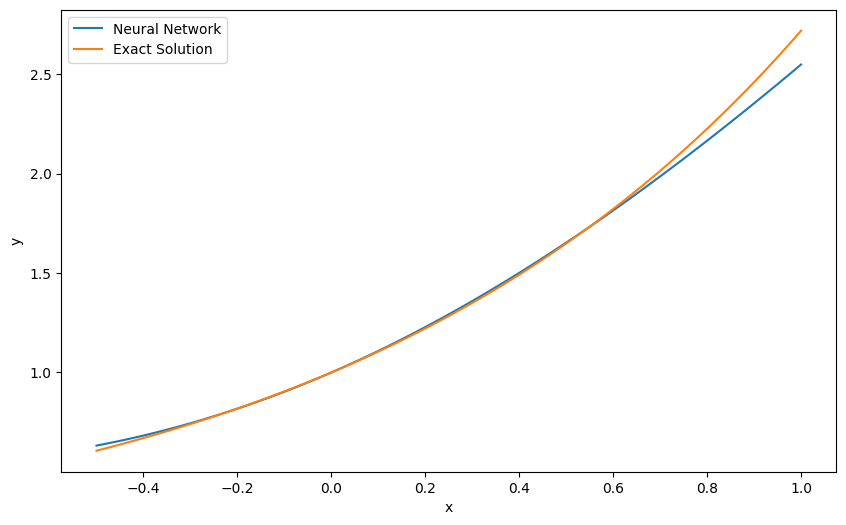

In [ ]:
# Convert model weights to numpy arrays for easier calculations
U_np = U.numpy()
V_np = V.numpy()
b_np = b.numpy()

# Plot actual vs NN solution
def neural_net_numpy(x_val, U_np, V_np, b_np):
    xsig = U_np * x_val / (1 + np.exp(-1 * (x_val * V_np + b_np)))
    return 1 + np.sum(xsig, axis=1)

# Define x values
x_values = np.linspace(-0.5, 1.0, 100)

# Calculate y values for the neural network and the exact solution
y_values_nn = [neural_net_numpy(x, U_np, V_np, b_np) for x in x_values]
y_values_exact = np.exp(x_values)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values_nn, label='Neural Network')
plt.plot(x_values, y_values_exact, label='Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 2D PDE example

The following is a solution to the Laplacian partial differential equation over the domain ${0}{\leq}{x}{\leq}{1}$ , ${0}{\leq}{y}{\leq}{1}$ with boundary conditions as the zero function for all edges except the right vertical
$$\frac{\partial^{2}\psi}{\partial{x^2}}+\frac{\partial^{2}\psi}{\partial{y^2}}={0}{\ } ,{\ }{\psi}({x},0)={\psi}({x},1)={\psi}(0,{y})=0{\ },{\ }{\psi}(1,{y})=y-y^2 $$
by means of approximating the solution with a double layer, fully connected neural network.



A trial solution of the form below is constructed so as to satisfy the boundary conditions explicitly.

$${\psi_{trial}=x(y-y^2)+(x-x^2)(y-y^2){\sum_{i=1}^N}}\frac{u_i}{1-e^{-(v_{i}x+w_{i}y+b)}}$$
{\ }

Each neuron in the net represents a sigmoidal basis function. Since the solution to the above PDE is a 2D surface, this requires sigmoidal functions of the form,

$$\frac{u_i}{1-e^{-(v_{i}x+w_{i}y+b)}}$$

that look like the surface below.





<img src="https://drive.google.com/uc?id=1txo_fdQmv-Pvy8YO2OXIWp-ny-9YvH08" width="600" />



\\

One can vary the number of domain points and basis functions used in order to build a cost function that sums up the trial solution evaluated at each point of the grid in each of the basis functions that together comprise the trial solution. The cost function is then made by plugging the sums of the basis functions above into the differential equation,

$${J={\sum}[\frac{\partial^{2}\psi}{\partial{x^2}}+\frac{\partial^{2}\psi}{\partial{y^2}}]^2}$$


The neural net offers an efficient and natural method for arranging the parameters of the trial solution. The cost function is then differentiated with respect to all the parameters of the basis functions and those gradient components are used for the backpropagation algorithm of one’s choosing. The  script below uses regular gradient descent.

#Neural Network Solver for Laplacian Equation#

In [ ]:
%%time
import numpy as np
import tensorflow as tf

np.random.seed(1)

# Domain and boundary conditions
x0, x1, y0, y1 = 0, 1, 0, 1
num_points = 64

# Generate grid points
x = np.linspace(x0, x1, num_points)
y = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack((X.ravel(), Y.ravel())).T

# Model weights and inputs initialized
U = tf.Variable(tf.random.normal([1, 10], dtype=tf.float64))
V = tf.Variable(tf.random.normal([1, 10], dtype=tf.float64))
W = tf.Variable(tf.random.normal([1, 10], dtype=tf.float64))
b = tf.Variable(tf.random.normal([1, 10], dtype=tf.float64))

# Learning rate
alpha = 0.1

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

def psi_trial(x, y, U, V, W, b):
    x = tf.expand_dims(x, axis=-1)
    y = tf.expand_dims(y, axis=-1)
    return x * (y - y ** 2) + (x - x ** 2) * (y - y ** 2) * tf.matmul(1 / (1 + tf.exp(-1 * (V * x + W * y + b))), U, transpose_b=True)

xy_grid = tf.Variable(grid_points, dtype=tf.float64)
x_grid = xy_grid[:, 0]
y_grid = xy_grid[:, 1]

for i in range(25):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as tape_x:
            with tf.GradientTape() as tape_xx:
                tape_xx.watch(x_grid)
                tape_x.watch(x_grid)
                psi = psi_trial(x_grid, y_grid, U, V, W, b)
                psi_x = tape_x.gradient(psi, x_grid)
            psi_xx = tape_xx.gradient(psi_x, x_grid)

        with tf.GradientTape() as tape_y:
            with tf.GradientTape() as tape_yy:
                tape_yy.watch(y_grid)
                tape_y.watch(y_grid)
                psi = psi_trial(x_grid, y_grid, U, V, W, b)
                psi_y = tape_y.gradient(psi, y_grid)
            psi_yy = tape_yy.gradient(psi_y, y_grid)

        laplace_psi = psi_xx + psi_yy
        loss = tf.reduce_sum(laplace_psi ** 2)

    gradients = tape.gradient(loss, [U, V, W, b])
    optimizer.apply_gradients(zip(gradients, [U, V, W, b]))

print("\n Final Loss: ", loss.numpy())
print("\n Final Weights")
print("\nU: ", U.numpy())
print("\nV: ", V.numpy())
print("\nW: ", W.numpy())
print("\nb: ", b.numpy())



 Final Loss:  1523.4640203298645

 Final Weights

U:  [[-0.85064352  0.01821491  1.30489164 -0.24142193 -0.95829259 -0.63504391
   0.86115625 -0.37244137  0.76882941 -2.00776337]]

V:  [[ 0.62558645 -1.08213481 -1.52315799 -0.16816713  2.28140868  1.06789602
  -0.6725704   1.11286358 -0.77165697 -0.53129745]]

W:  [[-1.71573283 -0.81711527 -2.78208191 -1.6141785   0.73882528 -1.58523734
  -0.54646198 -0.95600855 -0.41710001 -0.87313299]]

b:  [[ 0.38967677 -1.06991659  0.19354629 -0.6405867   2.89854986 -2.36637575
  -0.26218241 -0.54391932  0.51152602 -1.74343605]]
CPU times: user 2.76 s, sys: 11.6 ms, total: 2.77 s
Wall time: 3.01 s


#Plot of NN Solution#

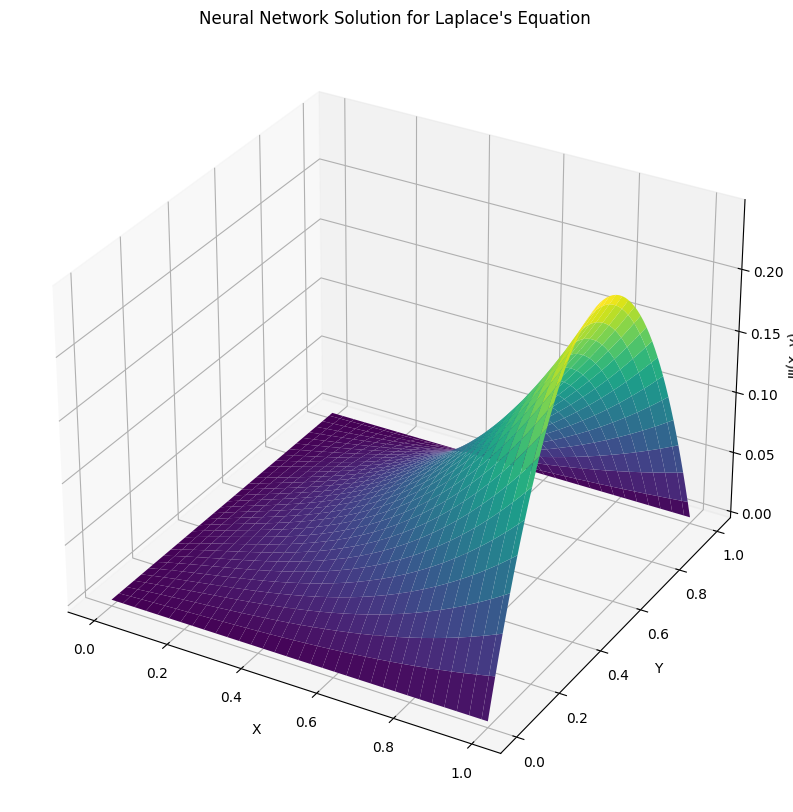

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

from mpl_toolkits.mplot3d import Axes3D  # Add this line

# Save the final weights
U_final = U.numpy()
V_final = V.numpy()
W_final = W.numpy()
b_final = b.numpy()

# Calculate the solution using the final weights
x_plot = np.linspace(x0, x1, num_points)
y_plot = np.linspace(y0, y1, num_points)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

grid_points_plot = np.vstack((X_plot.ravel(), Y_plot.ravel())).T
xy_grid_plot = tf.Variable(grid_points_plot, dtype=tf.float64)
x_grid_plot = xy_grid_plot[:, 0]
y_grid_plot = xy_grid_plot[:, 1]

psi_solution = psi_trial(x_grid_plot, y_grid_plot, U_final, V_final, W_final, b_final)
psi_solution_2D = tf.reshape(psi_solution, (num_points, num_points)).numpy()


# Plot the solution
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')  # Replace 'gca' with 'add_subplot'
ax.plot_surface(X_plot, Y_plot, psi_solution_2D, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('ψ(x, y)')
plt.title("Neural Network Solution for Laplace's Equation")
plt.show()

# Analytic Solution

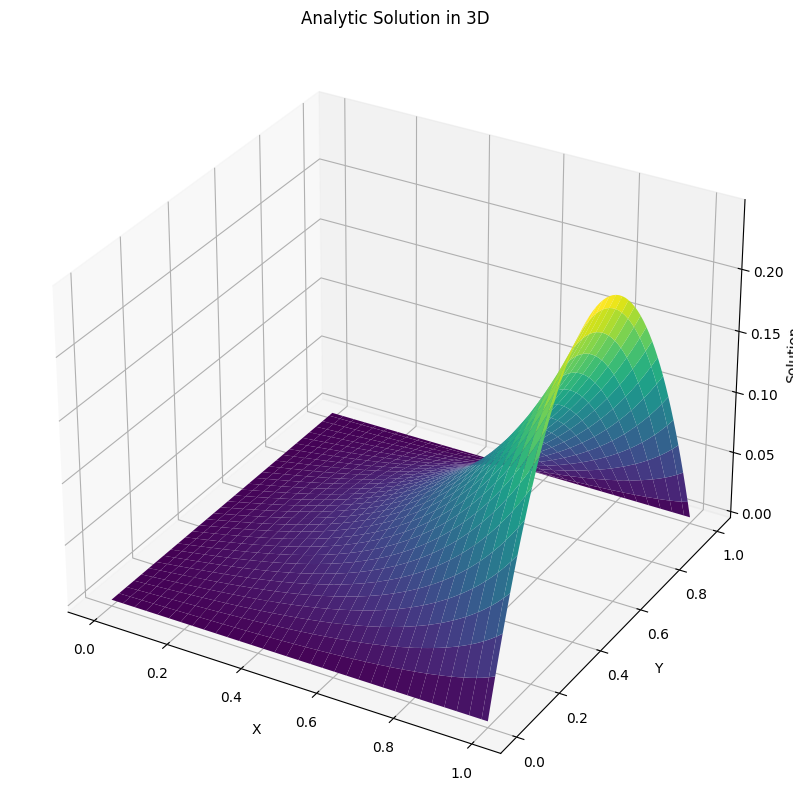

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Function for csch
def csch(x):
    return 1.0 / np.sinh(x)

# Function for the given solution
def analytic_solution(x, y, n_terms=200):
    K = np.arange(1, n_terms + 1)
    term = lambda k: -(4 * (-1 + (-1)**k) * csch(np.pi * k) * np.sin(np.pi * y * k) * np.sinh(np.pi * x * k)) / (np.pi**3 * k**3)
    return np.sum(np.array([term(k) for k in K]), axis=0)

# Generate x and y values
num_points = 64
x = np.linspace(0, 1, num_points)
y = np.linspace(0, 1, num_points)
X, Y = np.meshgrid(x, y)

# Compute the solution
Z = analytic_solution(X, Y)

# Plot the solution in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D plot
ax.plot_surface(X, Y, Z, cmap='viridis')  # Plot the surface
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution')
plt.title("Analytic Solution in 3D")
plt.show()


#Finite Difference Method Solution#

In [ ]:
%%time

import numpy as np
import matplotlib.pyplot as plt

# Define the grid
nx = 64
ny = 64
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Set the boundary conditions
psi_fd = np.zeros((ny, nx))
psi_fd[:, 0] = 0
psi_fd[:, -1] = Y[:, -1] - Y[:, -1]**2
psi_fd[0, :] = 0
psi_fd[-1, :] = 0

# Iteratively solve the Laplace equation
max_iter = 500
tol = 1e-5
error = 1
iter_count = 0

while error > tol and iter_count < max_iter:
    psi_old = psi_fd.copy()
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            psi_fd[j, i] = 0.25 * (psi_fd[j, i+1] + psi_fd[j, i-1] + psi_fd[j+1, i] + psi_fd[j-1, i])

    error = np.max(np.abs(psi_fd - psi_old))
    iter_count += 1



CPU times: user 2.5 s, sys: 7.03 ms, total: 2.51 s
Wall time: 2.51 s


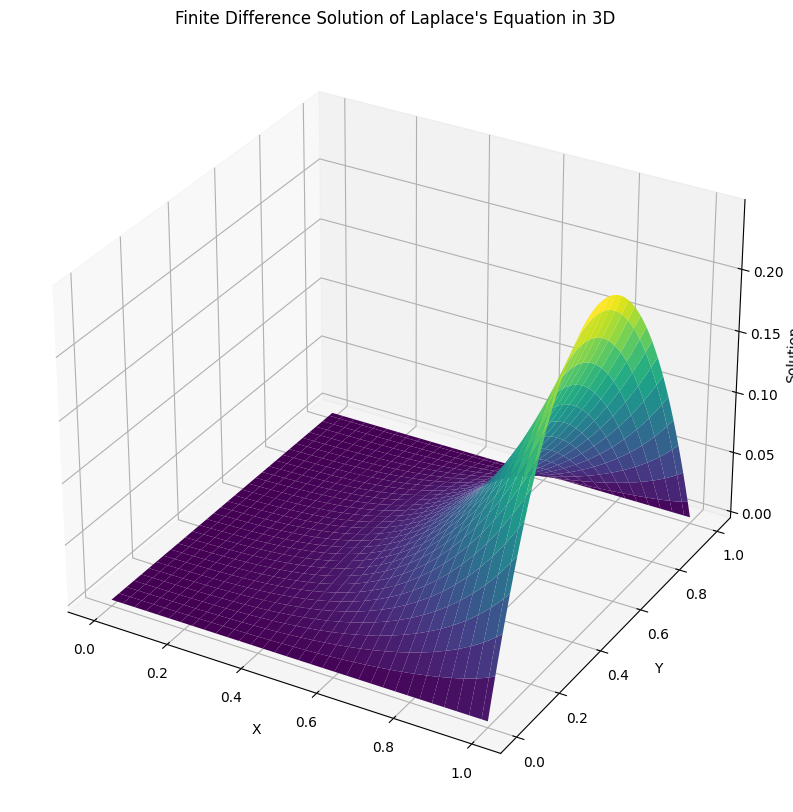

In [ ]:
# Plot the finite difference solution in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D plot
ax.plot_surface(X, Y, psi_fd, cmap='viridis')  # Plot the surface
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution')
plt.title("Finite Difference Solution of Laplace's Equation in 3D")
plt.show()

#Error Analysis#

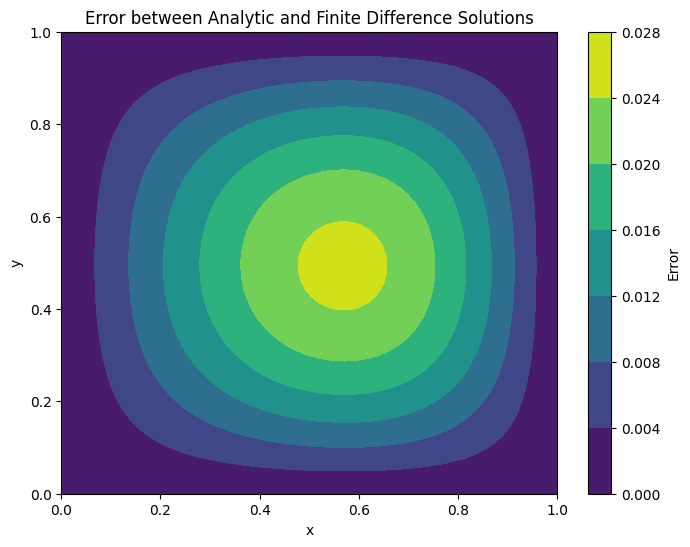

Maximum Error:  0.02512876358818661


In [ ]:
# Compute the analytical solution
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the finite difference solution
error = np.abs(psi_fd - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and Finite Difference Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


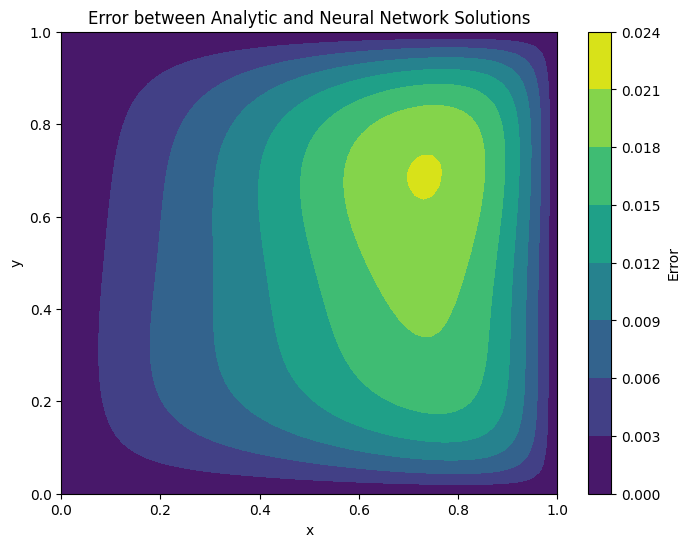

Maximum Error:  0.021197402328336945


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


#Leveraging TensorFlow Optimizations on GPUs for the NN Solver#

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In this script we decorate the gradient calculations which create a computational graph in TensorFLow that optimizes GPU use and dramatically decreases training time.

In [ ]:
%%time

import tensorflow as tf

# Define the psi_trial function outside for clarity
def psi_trial(x, y, U, V, W, b):
    x = tf.expand_dims(x, axis=-1)
    y = tf.expand_dims(y, axis=-1)
    return x * (y - y**2) + (x - x**2) * (y - y**2) * tf.matmul(1 / (1 + tf.exp(-1 * (V * x + W * y + b))), U, transpose_b=True)

# Decorate this function with tf.function for performance optimization
@tf.function
@tf.autograph.experimental.do_not_convert
def train_step(x_grid, y_grid, U, V, W, b, optimizer):
    with tf.GradientTape() as tape:
        with tf.GradientTape() as tape_x:
            with tf.GradientTape() as tape_xx:
                tape_xx.watch(x_grid)
                tape_x.watch(x_grid)
                psi = psi_trial(x_grid, y_grid, U, V, W, b)
                psi_x = tape_x.gradient(psi, x_grid)
            psi_xx = tape_xx.gradient(psi_x, x_grid)

        with tf.GradientTape() as tape_y:
            with tf.GradientTape() as tape_yy:
                tape_yy.watch(y_grid)
                tape_y.watch(y_grid)
                psi = psi_trial(x_grid, y_grid, U, V, W, b)
                psi_y = tape_y.gradient(psi, y_grid)
            psi_yy = tape_yy.gradient(psi_y, y_grid)

        laplace_psi = psi_xx + psi_yy
        loss = tf.reduce_sum(laplace_psi ** 2)

    gradients = tape.gradient(loss, [U, V, W, b])
    optimizer.apply_gradients(zip(gradients, [U, V, W, b]))
    return loss

# Initialize variables and optimizer as before

# Training loop
for i in range(25):
    loss = train_step(xy_grid[:, 0], xy_grid[:, 1], U, V, W, b, optimizer)
    if i % 5 == 0:
        print(f"Step {i}, Loss: {loss.numpy()}")

print("\n Final Loss: ", loss.numpy())
print("\n Final Weights")
print("U: ", U.numpy())
print("V: ", V.numpy())
print("W: ", W.numpy())
print("b: ", b.numpy())


Step 0, Loss: 720.6987607827391
Step 5, Loss: 701.8589797566977
Step 10, Loss: 656.9411381643283
Step 15, Loss: 639.6207763592679
Step 20, Loss: 607.158647771672

 Final Loss:  592.4229945734437

 Final Weights
U:  [[-0.77018469  0.03929952  1.11175047 -0.22513542 -1.12172935 -1.28500551
   0.82824383 -0.45491599  0.74403092 -1.76132601]]
V:  [[ 1.21462762 -1.16488626 -1.52457534  0.17002363  1.53233158  3.04315615
  -0.92222596  1.9719548  -1.18722487 -0.33750777]]
W:  [[-1.24983622 -0.90856308 -2.15004154 -2.22297623  0.96528796 -1.94643585
  -0.68710807 -0.35547461 -0.75970439 -1.23868509]]
b:  [[ 0.16380558 -1.16907382  0.20709527 -1.04008972  3.20200468 -2.70088384
  -0.28807127 -1.03645179  0.48933162 -1.98673168]]
CPU times: user 833 ms, sys: 3.05 ms, total: 836 ms
Wall time: 828 ms
Parser   : 245 ms


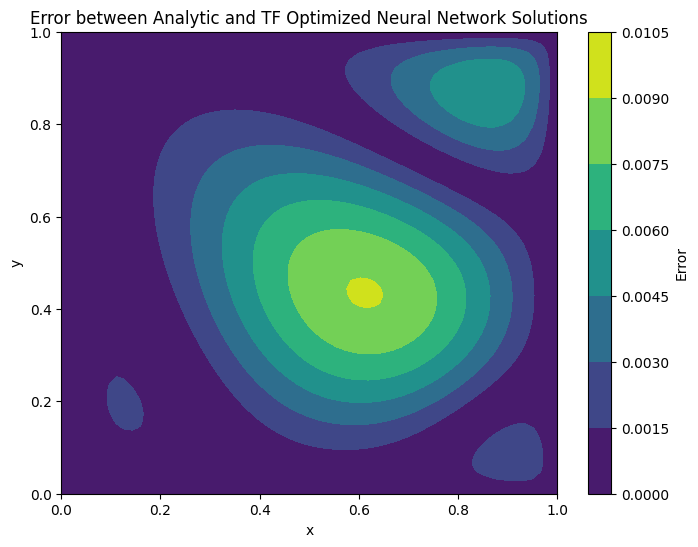

Maximum Error:  0.009097179734126742


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


#Conclusion#

We see that FD and NN methods have a comparable max error of ~0.02 and the FD method is faster (2.51 seconds for FD and 3.01 seconds for the NN solver).

However when the functions critical to training the NN solver are decorated and thus then compliled with computational graphs that TensorFlow uses to optimize neural network training on GPUs, we see significant improvement, better than the FD method implemented here. We see a training time of less than 1 second (833 ms) and a max error of ~0.009.

Further exploration would be to compare training times resulting in comparable error for FD methods iplemeted in C/C++ with NN methods optimized as above.


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))


In [ ]:
# Compute the solution on a grid
x_grid = np.linspace(x0, x1, num_points)
y_grid = np.linspace(y0, y1, num_points)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = np.reshape(X, [-1])
Y_flat = np.reshape(Y, [-1])

# Compute the neural network solution on the grid
with tf.GradientTape() as tape:
    psi_nn = psi_trial(X_flat, Y_flat, U, V, W, b)
psi_nn = np.reshape(psi_nn.numpy(), X.shape)

# Compute the analytical solution on the grid
Z_analytic = analytic_solution(X, Y)

# Compute the error between the analytical solution and the neural network solution
error = np.abs(psi_nn - Z_analytic)

# Plot the error
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, error, cmap="viridis")
plt.colorbar(label="Error")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Error between Analytic and TF Optimized Neural Network Solutions")
plt.show()

# Also print out the maximum error
print("Maximum Error: ", np.max(error))
